## Sentiment Analysis for Movie's Reviews
* Project Based on the Kaggle Competition "Bag of Words Meets Bags of Popcorn"

**Data Set **
* The data set consists of 100,000 IMDB movie reviews, specially selected for sentiment analysis. 
* The sentiment of reviews is binary, meaning the IMDB rating < 5 results in a sentiment score of 0, and rating >=7 have a sentiment score of 1. 
* No individual movie has more than 30 reviews.
* The 25,000 review labeled training set does not include any of the same movies as the 25,000 review test set. 
* In addition, there are another 50,000 IMDB reviews provided without any rating labels.

** File descriptions **
* **labeledTrainData** The file is tab-delimited and has a header row followed by 25,000 rows containing an id, sentiment, and text for each review.  
* **testData** The tab-delimited file has a header row followed by 25,000 rows containing an id and text for each review.
* **unlabeledTrainData** The tab-delimited file has a header row followed by 50,000 rows containing an id and text for each review. 

** Data fields **
* **id** - Unique ID of each review
* **sentiment** - Sentiment of the review; 1 for positive reviews and 0 for negative reviews
* **review** - Text of the review

In [15]:
# Importing all the libraries and tools used on this project

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot') # This styles the graphs in a nicer format

import nltk
import sklearn.linear_model
import textblob

# Other style of graphs
from bokeh.plotting import figure,show,output_notebook
from bokeh.models import Range1d
output_notebook()
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread

#Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,metrics,classification_report,confusion_matrix,roc_curve,auc
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

import sklearn.cluster
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup

Loading BokehJS ...

In [16]:
# Loading Data Sets using Pandas
train_data = pd.read_csv('labeledTrainData.tsv', header=0, delimiter="\t", quoting=3)
test_data = pd.read_csv('testData.tsv', header=0, delimiter="\t", quoting=3)
unlabeled_train_data = pd.read_csv('unlabeledTrainData.tsv', header=0, delimiter="\t", quoting=3)

In [17]:
# Visually inspecting the data sets
train_data.head()
print train_data.sentiment.value_counts()

test_data.head()
unlabeled_train_data.head()

1    12500
0    12500
Name: sentiment, dtype: int64


,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [18]:
# Visualising to see distribution of sentiment on training data

# create a new plot with a title and axis labels
p = figure(title="Number of Reviews per Sentiment", x_axis_label='Review Sentiment', y_axis_label='Number of Reviews')

hist, edges = np.histogram(train_data.sentiment.values, density=False, bins=2)
p.quad(top=hist, 
       bottom=0, 
       left=([ -0.25 ,  0.75]),
       right=([ 0.25,  1.25 ]),
       line_color='black',
       color=['red','green'],
      )
p.x_range = Range1d(-0.5, 1.5)

# show the results
show(p)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1206dc190>]], dtype=object)

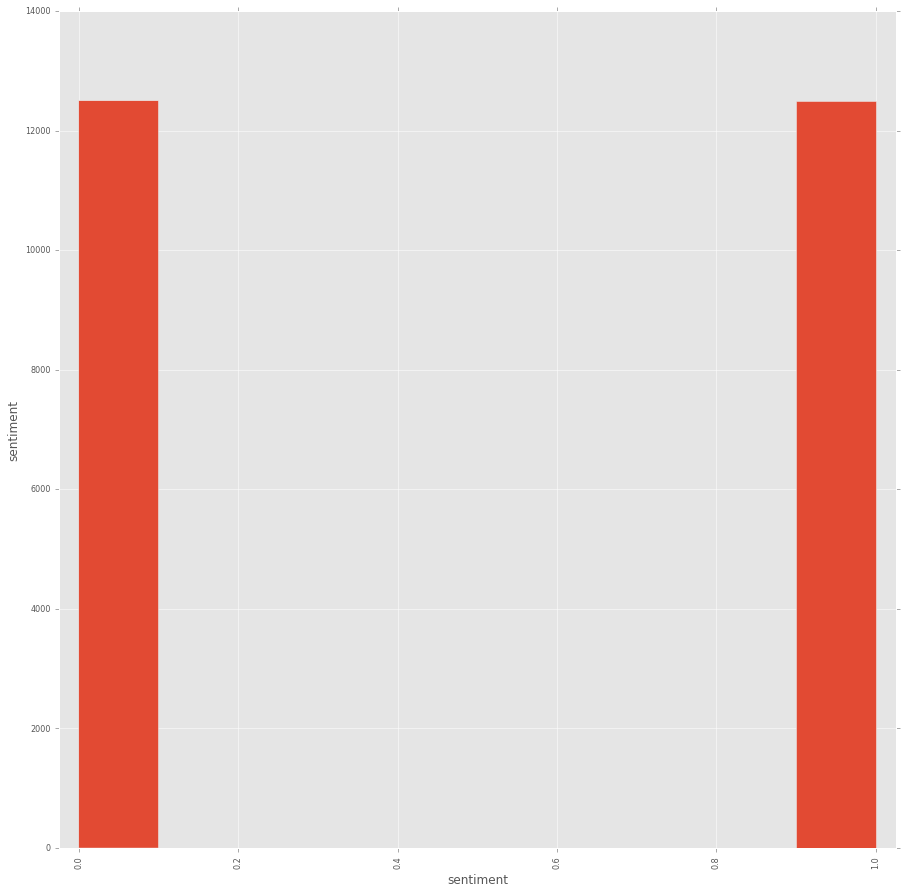

In [19]:
# Performing a Scatter Matrix on the Train Data
pd.scatter_matrix(train_data, figsize=(15,15))

In [20]:
# Further checking each data set
test_data.index
test_data.dtypes 
test_data.shape
print test_data.info()

train_data.index
train_data.dtypes 
train_data.shape
print train_data.info()

unlabeled_train_data.index
unlabeled_train_data.dtypes 
unlabeled_train_data.shape
print unlabeled_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
id        25000 non-null object
review    25000 non-null object
dtypes: object(2)
memory usage: 390.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
id        50000 non-null object
review    50000 non-null object
dtypes: object(2)
memory usage: 781.3+ KB
None


In [21]:
# Cheking one review of the train data
train_data["review"][18765]

'"I saw this film yesterday. I must admit, it weren\'t my cup of tea. Although it\'s supposed to be a horror movie of its kind. But as I was watching this, I was thinking.. \'This movie isn\'t making any sense at all..\' Where on earth did this guy in the dark coat came from? Where were the two guys were going when they left the girls behind? Where on earth did a shark came out from?<br /><br />All these elements in this film somehow didn\'t add up. I felt as if these filmmakers wasted so much time and money on a film that was so bound to be so crap.<br /><br />I\'ve seen many good horror movies in my time, but this is one of the most worst horror flicks I\'ve seen. At the end of the movie, I said to myself that I wouldn\'t watch it again.. So much pappy show in this film, I\'ve decided to give it the thumbs down! Count me out on this one! 0 out of 10!"'

In [22]:
# Checking one review of the test data
test_data["review"][345]

'"Note to self. Never ever ever again watch a serious movie with Charlie Sheen in it. Great comedian, horrible seal. This movie makes Navy SEALS look like a reckless group of rangers when, in fact, they are the most elite form of military in the world. Charlie Sheen helps destroy the Navy SEAL reputation. Thank you for making such an incredibly select group of individuals look awful in one of the worst action movies I have ever seen. This is a great story which could be made into an amazing action movie, but why Charlie Sheen? There are possibilities for a very passionate story here, but Sheen decides to wreck them with \\"funny\\" comments."'

In [23]:
# Checking one review of the unlabeled train data
unlabeled_train_data["review"][9000]

'"Jim Jarmusch\'s \\"Night on Earth\\" is what one could call an international American movie - and therefore almost a contradiction. When normally Americans come to Paris, to Madrid or to Rome, the movies in which they act look like these cities would lie in the US. Not only there is exclusively English spoken, but the actors do not behave as if they were in Europe. Sadly enough, this is even true for Soderberg\'s \\"The Good German\\". The worst that can happen, then, is that Americans try to film European history. I do not watch such movies anymore until Unviersal will have agreed to contract Fredy Murer as director of a new American Western.<br /><br />Very different are the movies of the world-versatile Jarmusch, a real Odysseus for whom the Greek attribute \\"polytropos\\" could not better fit - also what the choice of his movies concerns. Although the situations in the different taxi-drives are acted, they are so good as in real life. In order not to spoil the real pleasure that

In [24]:
# Further checking each data set with describe
print train_data.describe(include='all')
print test_data.describe(include='all')
print unlabeled_train_data.describe(include='all')

# Non-unique reviews numbers on each data set
print 25000-len(set(train_data['review']))
print 25000-len(set(test_data['review']))
print 50000-len(set(unlabeled_train_data['review']))

              id    sentiment  \
count      25000  25000.00000   
unique     25000          NaN   
top     "4189_1"          NaN   
freq           1          NaN   
mean         NaN      0.50000   
std          NaN      0.50001   
min          NaN      0.00000   
25%          NaN      0.00000   
50%          NaN      0.50000   
75%          NaN      1.00000   
max          NaN      1.00000   

                                                   review  
count                                               25000  
unique                                              24904  
top     "When i got this movie free from my job, along...  
freq                                                    3  
mean                                                  NaN  
std                                                   NaN  
min                                                   NaN  
25%                                                   NaN  
50%                                                   NaN  
75%

In [25]:
# Checking data sets to see if there is any empty values
train_data.head()
train_data[train_data.id.isnull() == True]
train_data[train_data.sentiment.isnull() == True]
train_data[train_data.review.isnull() == True]

test_data.head()
test_data[train_data.id.isnull() == True]
test_data[train_data.review.isnull() == True]

unlabeled_train_data.head()
unlabeled_train_data[unlabeled_train_data.id.isnull() == True]
unlabeled_train_data[unlabeled_train_data.review.isnull() == True]

,id,review


In [26]:
#Further checking each data set
train_data.review.describe()
train_data.shape

test_data.review.describe()
test_data.shape

unlabeled_train_data.describe()
unlabeled_train_data.shape

(50000, 2)

### Start of the Classification Approach

In [27]:
# Instantiate Vectorizers
# Learn the Review Vocabulary of the Training Data

#Count Vectorizer
count_vect = CountVectorizer(stop_words='english', decode_error = 'ignore')
count_vect_unlabeled = CountVectorizer(stop_words='english', decode_error = 'ignore')
count_vect_kmeans = CountVectorizer(stop_words='english', decode_error = 'ignore')

bag_of_words_train = count_vect.fit_transform(train_data['review'])
bag_of_words_unlabeled = count_vect_unlabeled.fit_transform(unlabeled_train_data['review'])

# Data for KMeans due to high processing time
bag_of_words_train_kmeans = count_vect_kmeans.fit_transform(train_data['review'].head(5000))
y_train_data = train_data['sentiment'].head(5000)

In [28]:
# Checking the output of Training Bag
print bag_of_words_train.todense().shape

# Checking the output of Training Bag
print bag_of_words_unlabeled.todense().shape

(25000, 74539)
(50000, 102751)


In [29]:
# CV Vocabulary words
vocabulary_words = list(count_vect.get_feature_names())
count_vect.get_params

vocabulary_words_unlabeled = list(count_vect_unlabeled.get_feature_names())
count_vect_unlabeled.get_params

<bound method CountVectorizer.get_params of CountVectorizer(analyzer=u'word', binary=False, decode_error='ignore',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)>

In [30]:
# Splitting the Train Data (Labeled)
X_train,X_test,y_train,y_test = train_test_split(bag_of_words_train,
                                                 train_data['sentiment'],
                                                 random_state=42,test_size=0.2
                                                )

##### Dummy Classifier

In [31]:
# Dummy Classifier and Scoring
Dummy = DummyClassifier(strategy='most_frequent')

Dummy.fit(X_train, y_train)
Dummy_predictions = Dummy.predict(X_test)

print Dummy.score(X_test,y_test)
print accuracy_score(y_test, Dummy_predictions)
#print cross_val_score(Dummy,X_test,y_test,cv=100).mean()
print "%.4f" % cross_val_score(Dummy,X_test,y_test,cv=100).mean()

0.4962
0.4962
0.5038


In [32]:
#Dummy Confusion Matrix 
Dummy_confusion_matrix = confusion_matrix(y_test,Dummy_predictions)

cm_df = pd.DataFrame(Dummy_confusion_matrix,
                     columns=['Predicted Class 0', 'Predicted Class 1'], 
                     index=['Actual Class 0', 'Actual Class 1']
                    )

print "Results of Linear Regression: "
print cm_df,'\n'
#print "Precision:",float(Dummy_confusion_matrix[1,1])/(Dummy_confusion_matrix[0,1]+Dummy_confusion_matrix[1,1])
#print "Recall:",float(Dummy_confusion_matrix[1,1])/(Dummy_confusion_matrix[1,0]+Dummy_confusion_matrix[1,1]),'\n'
print "============================================"

Results of Linear Regression: 
                Predicted Class 0  Predicted Class 1
Actual Class 0               2481                  0
Actual Class 1               2519                  0 



##### Naive Bayes Classifier

In [51]:
#Naive Bayes Classification
NB_classifier = MultinomialNB().fit(X_train, y_train)

In [52]:
#Naive Bayes Scoring
NB_predictions = NB_classifier.predict(X_test)

print NB_classifier.score(X_test,y_test)
print accuracy_score(y_test, NB_predictions)

print "%.4f" % cross_val_score(NB_classifier,X_test,y_test,cv=100).mean()

0.8584
0.8584
0.8444


In [55]:
# NB Confusion Matrix and Classification Report
NB_confusion_matrix = confusion_matrix(y_test,NB_predictions)

cm_df = pd.DataFrame(NB_confusion_matrix,
                     columns=['Predicted Class 0', 'Predicted Class 1'], 
                     index=['Actual Class 0', 'Actual Class 1']
                    )

print "Results of Multinomial Naive Bayes: "
print cm_df,'\n'
print "Precision:",float(NB_confusion_matrix[1,1])/(NB_confusion_matrix[0,1]+NB_confusion_matrix[1,1])
print "Recall:",float(NB_confusion_matrix[1,1])/(NB_confusion_matrix[1,0]+NB_confusion_matrix[1,1]),'\n'
print "============================================"

print classification_report(y_test,NB_predictions,target_names=['Class 0','Class 1'])

Results of Multinomial Naive Bayes: 
                Predicted Class 0  Predicted Class 1
Actual Class 0               2175                306
Actual Class 1                402               2117 

Precision: 0.873710276517
Recall: 0.840412862247 

             precision    recall  f1-score   support

    Class 0       0.84      0.88      0.86      2481
    Class 1       0.87      0.84      0.86      2519

avg / total       0.86      0.86      0.86      5000



### GridSearch and Pipeline

In [134]:
# Perform a train test split with the whole train data
X_train_r,X_test_r,y_train_r,y_test_r = train_test_split(train_data['review'],train_data['sentiment'], random_state=42,test_size=0.2)

In [135]:
# Building a Classifier using Vectorizer and best classifier model
# Originally ran this without the C=0.1. This value was obtained after performing a Grid Search below
text_clf = Pipeline([('vect', CountVectorizer(CountVectorizer(stop_words='english', decode_error = 'ignore'))),
                     ('clf', (LogisticRegression(C=0.1))) ])
fit_pipe = text_clf.fit(X_train_r,y_train_r)

In [136]:
PI_predictions = fit_pipe.predict(X_test_r)

In [137]:
print fit_pipe.score(X_test_r,y_test_r)
print accuracy_score(y_test_r, PI_predictions)

print "%.4f" % cross_val_score(text_clf,X_test_r,y_test_r,cv=100).mean()

0.8912
0.8912
0.8588


In [138]:
# Pipeline Confusion Matrix and Classification Report
PI_confusion_matrix = confusion_matrix(y_test,PI_predictions)

cm_df = pd.DataFrame(PI_confusion_matrix,
                     columns=['Predicted Class 0', 'Predicted Class 1'], 
                     index=['Actual Class 0', 'Actual Class 1']
                    )

print "Results of Pipeline: "
print cm_df,'\n'
print "Precision:",float(PI_confusion_matrix[1,1])/(PI_confusion_matrix[0,1]+PI_confusion_matrix[1,1])
print "Recall:",float(PI_confusion_matrix[1,1])/(PI_confusion_matrix[1,0]+PI_confusion_matrix[1,1]),'\n'
print "============================================"

print classification_report(y_test,PI_predictions,target_names=['Class 0','Class 1'])


Results of Pipeline: 
                Predicted Class 0  Predicted Class 1
Actual Class 0               2190                291
Actual Class 1                253               2266 

Precision: 0.886194759484
Recall: 0.899563318777 

             precision    recall  f1-score   support

    Class 0       0.90      0.88      0.89      2481
    Class 1       0.89      0.90      0.89      2519

avg / total       0.89      0.89      0.89      5000



In [139]:
PI_target_predicted_proba = text_clf.predict_proba(X_test_r)
plot_roc_curve(y_test_r, PI_target_predicted_proba)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


In [140]:
y_test_r.value_counts()

1    2519
0    2481
Name: sentiment, dtype: int64

In [141]:
# Run the model for the unseen trained data which is not labeled
PI_unlabeled_predictions = fit_pipe.predict(unlabeled_train_data['review'])

In [142]:
unlabeled_train_data['sentiment'] = PI_unlabeled_predictions
#unlabeled_train_data.loc[8].review
#unlabeled_train_data.head(10)
unlabeled_train_data.sentiment.value_counts()

0    25104
1    24896
Name: sentiment, dtype: int64

In [143]:
p10 = figure(title="Number of Reviews per Sentiment", x_axis_label='Review Sentiment', y_axis_label='Number of Reviews')

hist, edges = np.histogram(unlabeled_train_data.sentiment.values, density=False, bins=2)
p10.quad(top=hist, 
       bottom=0, 
       left=([ -0.25 ,  0.75]),
       right=([ 0.25,  1.25 ]),
       line_color='black',
       color=['red','green'],
      )
p10.x_range = Range1d(-0.5, 1.5)

# show the results
show(p10)

In [146]:
# Preparing parameters to perform a Grid Search with the Pipeline Classifier
parameters = {'vect__min_df':[1,2,3],
              'vect__max_df':[50,100,1000,10000]
             }

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=1)

In [147]:
# This last long time processing!
fit_grid = gs_clf.fit(X_train_r,y_train_r)

KeyboardInterrupt: 

In [194]:
fit_grid.score(X_test_r,y_test_r)

0.84840000000000004

In [257]:
fit_grid.best_params_

{'clf__alpha': 1, 'vect__max_df': 1000, 'vect__min_df': 1}

##### Decision Tree Classifier

In [56]:
#Decision Tree and Scoring
DT_classifier = DecisionTreeClassifier()
DT_classifier.fit(X_train, y_train)
DT_predictions = DT_classifier.predict(X_test)

print DT_classifier.score(X_test,y_test)
print accuracy_score(y_test, DT_predictions)
print "%.4f" % cross_val_score(DT_classifier,X_test,y_test,cv=100).mean()
#### REVIEW!!!! Change presentation

0.7174
0.7174
0.8444


##### Random Forests

In [57]:
# Random Forests
rfclf = RandomForestClassifier(n_estimators=200,max_features='auto', oob_score=True, random_state=1)
rfclf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

In [59]:
#Random Forests Scoring (This last too long on processing)
rfclf_predictions = rfclf.predict(X_test)
print accuracy_score(y_test, rfclf_predictions)
print rfclf.oob_score_
print "%.4f" % cross_val_score(rfclf,X_test,y_test,cv=100).mean()
rfclf.feature_importances_

0.857
0.84805


KeyboardInterrupt: 

In [60]:
# Random Forests Confusion Matrix and Classification Report
RF_confusion_matrix = confusion_matrix(y_test,rfclf_predictions)

cm_df = pd.DataFrame(RF_confusion_matrix,
                     columns=['Predicted Class 0', 'Predicted Class 1'], 
                     index=['Actual Class 0', 'Actual Class 1']
                    )

print "Results of Random Forests: "
print cm_df,'\n'
print "Precision:",float(RF_confusion_matrix[1,1])/(RF_confusion_matrix[0,1]+RF_confusion_matrix[1,1])
print "Recall:",float(RF_confusion_matrix[1,1])/(RF_confusion_matrix[1,0]+RF_confusion_matrix[1,1]),'\n'
print "============================================"

print classification_report(y_test,rfclf_predictions,target_names=['Class 0','Class 1'])

Results of Random Forests: 
                Predicted Class 0  Predicted Class 1
Actual Class 0               2122                359
Actual Class 1                356               2163 

Precision: 0.857652656622
Recall: 0.858674077015 

             precision    recall  f1-score   support

    Class 0       0.86      0.86      0.86      2481
    Class 1       0.86      0.86      0.86      2519

avg / total       0.86      0.86      0.86      5000



In [61]:
#Feature Importances
Feature_Importance = pd.DataFrame({'feature':vocabulary_words, 'importance':rfclf.feature_importances_})
Feature_Importance[Feature_Importance.importance != 0].sort('importance', ascending=False).head(20)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,feature,importance
5469,bad,0.012773
73397,worst,0.010139
28437,great,0.007614
71954,waste,0.007135
5234,awful,0.005946
8462,boring,0.004256
22825,excellent,0.004235
65919,terrible,0.003760
6998,best,0.003756
73380,worse,0.003662


##### K-Nearest Neighbors Classifier

In [62]:
#KNN
KNN_classifier = KNeighborsClassifier().fit(X_train, y_train)
print KNN_classifier.score(X_test,y_test)

KNN_predictions = KNN_classifier.predict(X_test)
print accuracy_score(y_test, KNN_predictions)
print "%.4f" % cross_val_score(KNN_classifier,X_test,y_test,cv=100).mean()

0.5796
0.5796
0.5692


##### Logistic Regression Classifier

In [63]:
# Logistic Regression
LR = LogisticRegression(C=0.1).fit(X_train,y_train)
LR_predictions = LR.predict(X_test)

#cross_val_score(LR,X_test,y_test,cv=100)
#print cross_val_score(LR,X_test,y_test,cv=100).mean()
print "%.4f" % cross_val_score(LR,X_test,y_test,cv=100).mean()
print accuracy_score(y_test, LR_predictions)

0.8667
0.8844


In [64]:
#LR.predict(bag_of_words_unlabeled)
# Obtained Error indicating "ValueError: X has 102751 features per sample; expecting 74539"

In [65]:
y_test.value_counts()
#LR_test_predictions = LR.predict(count_vect_test)

1    2519
0    2481
Name: sentiment, dtype: int64

In [66]:
# LR Confusion Matrix and Classification Report
LR_confusion_matrix = confusion_matrix(y_test,LR_predictions)

#lets make that easier to read
cm_df = pd.DataFrame(LR_confusion_matrix,
                     columns=['Predicted Class 0', 'Predicted Class 1'], 
                     index=['Actual Class 0', 'Actual Class 1']
                    )

print "Results of Logistic Regression: "
print cm_df,'\n'
print "Precision:",float(LR_confusion_matrix[1,1])/(LR_confusion_matrix[0,1]+LR_confusion_matrix[1,1])
print "Recall:",float(LR_confusion_matrix[1,1])/(LR_confusion_matrix[1,0]+LR_confusion_matrix[1,1]),'\n'
print "============================================"

print classification_report(y_test,LR_predictions,target_names=['Class 0','Class 1'])

Results of Logistic Regression: 
                Predicted Class 0  Predicted Class 1
Actual Class 0               2165                316
Actual Class 1                262               2257 

Precision: 0.877186164011
Recall: 0.89599047241 

             precision    recall  f1-score   support

    Class 0       0.89      0.87      0.88      2481
    Class 1       0.88      0.90      0.89      2519

avg / total       0.88      0.88      0.88      5000



In [67]:
# Defining the ROC curve in order to draw it and further examine AUC value
def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    
    p = figure(title='Receiver Operating Characteristic')
    # Plot ROC curve
    p.line(x=fpr,y=tpr,legend='ROC curve (area = %0.3f)' % roc_auc)
    p.x_range=Range1d(0,1)
    p.y_range=Range1d(0,1)
    p.xaxis.axis_label='False Positive Rate or (1 - Specifity)'
    p.yaxis.axis_label='True Positive Rate or (Sensitivity)'
    p.legend.orientation = "bottom_right"
    show(p)
%matplotlib inline

In [68]:
# Plotting all the different ROC curves for the best perfocmance classifiers
LR_target_predicted_proba = LR.predict_proba(X_test)
RF_target_predicted_proba = rfclf.predict_proba(X_test)
NB_target_predicted_proba = NB_classifier.predict_proba(X_test)

plot_roc_curve(y_test, LR_target_predicted_proba)
plot_roc_curve(y_test, RF_target_predicted_proba)
plot_roc_curve(y_test, NB_target_predicted_proba)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


In [69]:
# Checking Coefficients and Fetures from Logistic Regression (LR)
LR.coef_.ravel().shape
Feature_Importance_LR = pd.DataFrame({'feature':vocabulary_words, 'importance':LR.coef_.ravel()})

In [70]:
#Checking the Top 10 Positive Features (LR model)
Feature_Importance_LR = pd.DataFrame({'feature':vocabulary_words, 'importance':LR.coef_.ravel()})
Top10_Positive = Feature_Importance_LR[Feature_Importance_LR.importance != 0].sort('importance', ascending=False).head(10)
Top10_Positive

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,feature,importance
22825,excellent,0.835989
49024,perfect,0.742493
73193,wonderful,0.709979
26276,funniest,0.700393
54176,refreshing,0.698588
23913,favorite,0.693884
64416,surprisingly,0.690852
2937,amazing,0.683472
64169,superb,0.682266
39427,loved,0.679284


In [71]:
#Plotting Possitive Features
p2 = figure(title="Top 10 Positive Coefficients", x_axis_label='Feature Index', y_axis_label='Coefficient Value')

coefficients=Top10_Positive.importance
x = Top10_Positive.index
i = 0
for val in x:
    p2.quad(top = Top10_Positive.importance.loc[val],
            bottom=0, 
            left=val+800,
            right=val+1200,
            color=['red','orange','green','purple','grey','cyan','magenta','black','blue','brown'][i],
            legend=Top10_Positive.feature.loc[val]
            )
    i = i + 1
p2.y_range = Range1d(min(coefficients)-0.5, max(coefficients)+0.75)
show(p2)

In [72]:
#Checking the Top 10 Negative Features (LR model)
Top10_Negative = Feature_Importance_LR[Feature_Importance_LR.importance != 0].sort('importance', ascending=True).head(10)
Top10_Negative

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
73397,worst,-1.377554
71954,waste,-1.361911
18576,disappointment,-1.037613
5234,awful,-1.005329
18574,disappointing,-0.958968
50622,poorly,-0.958675
8462,boring,-0.947124
73380,worse,-0.828844
37296,lacks,-0.803743
5176,avoid,-0.775535


In [73]:
#Plotting Negative Features
p3 = figure(title="Top 10 Negative Coefficients", x_axis_label='Feature Index', y_axis_label='Coefficient Value')

coefficients=Top10_Negative.importance
x = Top10_Negative.index
i = 0
for val in x:
    p3.quad(top = Top10_Negative.importance.loc[val],
            bottom=0, 
            left=val+800,
            right=val+1200,
            color=['red','orange','green','purple','grey','cyan','magenta','black','blue','brown'][i],
            legend=Top10_Negative.feature.loc[val]
#            legend.orientation = "bottom_right"
            )
    i = i + 1
p3.legend.orientation = "bottom_center"
p3.y_range = Range1d(min(coefficients)-0.5, max(coefficients)+0.75)
show(p3)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


In [74]:
#Absolute Values of Coefficients
Feature_Importance_LR['absolute']=np.absolute(Feature_Importance_LR.importance)
Feature_Importance_LR.sort('absolute', ascending=False).head(20)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,feature,importance,absolute
73397,worst,-1.377554,1.377554
71954,waste,-1.361911,1.361911
18576,disappointment,-1.037613,1.037613
5234,awful,-1.005329,1.005329
18574,disappointing,-0.958968,0.958968
50622,poorly,-0.958675,0.958675
8462,boring,-0.947124,0.947124
22825,excellent,0.835989,0.835989
73380,worse,-0.828844,0.828844
37296,lacks,-0.803743,0.803743


In [639]:
# Selecting the best C value for Logistic Regression
parameters = {'C':[1000, 100, 10, 1, 0.1, 0.01, 0.001, .0001]
             }
GridSearch_LR = GridSearchCV(LR,
                             parameters,
                             cv=100
                            )

In [642]:
# Execution time of this Grid Search took too long
Fit_GS_LR = GridSearch_LR.fit(X_train,y_train)

In [736]:
Fit_GS_LR.best_params_

{'C': 0.1}

In [737]:
Fit_GS_LR.best_score_

0.88360000000000005

In [774]:
Fit_GS_LR.best_estimator_

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [782]:
Fit_GS_LR.grid_scores_

[mean: 0.85985, std: 0.02450, params: {'C': 1000},
 mean: 0.86425, std: 0.02459, params: {'C': 100},
 mean: 0.86995, std: 0.02264, params: {'C': 10},
 mean: 0.87580, std: 0.02253, params: {'C': 1},
 mean: 0.88360, std: 0.02209, params: {'C': 0.1},
 mean: 0.87605, std: 0.02049, params: {'C': 0.01},
 mean: 0.84460, std: 0.02212, params: {'C': 0.001},
 mean: 0.78405, std: 0.02739, params: {'C': 0.0001}]

In [75]:
# Exploring the wrong predcitions
wrong_predictions = []
for predicted,test,i in zip(LR.predict(X_test),y_test.values,y_test.index):
    if predicted==test:
        pass
    else:
        wrong_predictions.append(i)

In [76]:
train_data.loc[wrong_predictions]
wrong_predictions_df = train_data.loc[wrong_predictions]

In [77]:
zip(LR.predict(X_test),y_test.values,y_test.index)

[(0, 0, 6868),
 (1, 1, 24016),
 (0, 0, 9668),
 (1, 1, 13640),
 (0, 0, 14018),
 (1, 1, 7488),
 (1, 1, 5804),
 (1, 0, 12909),
 (0, 0, 3386),
 (1, 0, 9567),
 (0, 0, 21423),
 (0, 0, 3503),
 (0, 0, 6657),
 (1, 1, 19192),
 (1, 1, 2518),
 (1, 1, 13361),
 (0, 0, 21135),
 (1, 1, 21080),
 (1, 0, 6492),
 (0, 0, 6891),
 (1, 1, 7752),
 (0, 0, 8614),
 (0, 1, 6649),
 (1, 1, 2227),
 (1, 1, 12060),
 (0, 0, 19122),
 (1, 1, 9622),
 (1, 1, 12279),
 (1, 0, 16447),
 (1, 1, 423),
 (0, 0, 14337),
 (0, 0, 22163),
 (1, 1, 19839),
 (0, 0, 12456),
 (1, 1, 10277),
 (0, 0, 23085),
 (1, 1, 1805),
 (0, 1, 2790),
 (1, 1, 24427),
 (1, 1, 17716),
 (1, 0, 4972),
 (1, 1, 7613),
 (1, 1, 17238),
 (0, 0, 13570),
 (0, 0, 7946),
 (0, 0, 5100),
 (1, 1, 23948),
 (0, 0, 21182),
 (0, 0, 733),
 (0, 0, 18404),
 (0, 0, 3848),
 (0, 1, 22714),
 (0, 0, 9888),
 (0, 0, 4405),
 (1, 0, 22683),
 (0, 0, 3352),
 (1, 1, 15191),
 (0, 0, 15694),
 (0, 0, 19946),
 (1, 0, 14354),
 (1, 1, 21742),
 (1, 1, 18353),
 (1, 1, 17580),
 (0, 0, 22488),
 (1, 1

In [78]:
wrong_predictions_df.loc[9567]['review']

'"** HERE BE SPOILERS ** <br /><br />Recap: Mia (Helin) is returning home from capital Stockholm to rural R\xc3\xa4ttvik to celebrate her fathers 70th birthday. She is by far the youngest child, and has two sisters Eivor (Ernst) and Gunilla (Petr\xc3\xa9n). Eivor has a family and still lives in R\xc3\xa4ttvik and Gunilla has divorced and moved a town away. Mia is still single and is focused on her career. There are a lot of jealousy and almost animosity between the sisters and conflicts arise all around as they confront each other and each have personal problems they have difficult to handle. As the party goes on (and alcohol consumed), more and more secrets become unveiled and more and more conflicts arise...<br /><br />Comments: To be the work of a new writer/director it was disappointing to see this movie to follow in the exact same tracks that older Swedish comedy/dramas has been following for years. There are really no new elements or ideas. This movie draws upon three basic areas

#### Some further processing to investigate the relation of words with positive or negative reviews

In [79]:
#count_vect.fit(X_train)
count_vect.get_feature_names()
train_features = count_vect.get_feature_names()

In [80]:
# Transforming training and test data into document-term matrix

#train_dtmatrix = count_vect.transform(X_train)
#test_dtmatrix = count_vect.transform(X_test)

#print test_dtmatrix
#print test_dtmatrix

In [148]:
train_words = count_vect.get_feature_names()
len(train_words)
#train_words

74539

In [87]:
train_array = bag_of_words_train.toarray()
train_array.shape

# Reducing array for KMeans
train_array_kmeans = bag_of_words_train_kmeans.toarray()
train_array_kmeans.shape

(5000, 39031)

In [83]:
print train_array.shape
# Occurrences of word Excellent
print np.sum(train_array[:,22825])

(25000, 74539)
2071


In [84]:
print np.sum(train_array, axis=0)

[ 93 300   1 ...,   1   4   1]


In [85]:
train_token_counts = pd.DataFrame({'token':train_features, 'count':np.sum(train_array, axis=0)})
train_token_counts.sort_index(by='count', ascending=False).head(20)
#train_token_counts_kmeans = pd.DataFrame({'token':train_features_kmeans, 'count':np.sum(train_array_kmeans, axis=0)})
#train_token_counts_kmeans.sort_index(by='count', ascending=False)

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app


,count,token
8672,101871,br
43990,44047,movie
24445,40159,film
38612,20281,like
35649,17774,just
27960,15147,good
66668,12727,time
63195,11988,story
53637,11738,really
5469,9308,bad


### Attempt to K-Means Clustering
This attempt was performed on a reduce training set due to the amount of time it took for processing. I did not try DBSCAN as the memory consumption durign processing would not allow completion

In [88]:
kmeans_clusterer = sklearn.cluster.KMeans(init='k-means++', n_clusters=2)
movie_sentiment_cluster_kmeans = kmeans_clusterer.fit_predict(train_array_kmeans)

In [89]:
kmeans_clusterer.cluster_centers_
movie_sentiment_cluster_kmeans

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [91]:
review_colors = np.array(['red','green'])
# Green means good review
# Red means bad review
review_colors[movie_sentiment_cluster_kmeans]

array(['red', 'green', 'green', ..., 'green', 'green', 'green'], 
      dtype='|S5')

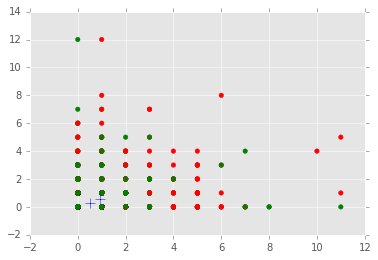

In [92]:
plt.scatter(train_array_kmeans[:,14799],
                          train_array_kmeans[:,2791],
                          color=review_colors[movie_sentiment_cluster_kmeans]
                         )
plt.scatter(kmeans_clusterer.cluster_centers_[:,14799],
                          kmeans_clusterer.cluster_centers_[:,2791],
                          marker='+',
                          s=120
                         )
#It seems clustering ont Cannot make sense of the below

### NLP Analysis

In [93]:
# Gathering negative and positive reviews in separate data frames
negative_review_train_data = train_data[train_data.sentiment == 0]
#negative_review_train_data

positive_review_train_data = train_data[train_data.sentiment == 1]
#negative_review_train_data

In [94]:
# Preparing to do some wordcloud diagrams
vect = CountVectorizer(decode_error='ignore')

In [95]:
# Learn the vocabulary of ALL messages and save it
vect.fit(train_data.review)
all_features = vect.get_feature_names()

In [96]:
# Create document-term matrix of positive and negative reviews, then convert to a regular array
good_dtm = vect.transform(positive_review_train_data.review)
good_arr = good_dtm.toarray()

bad_dtm = vect.transform(negative_review_train_data.review)
bad_arr = bad_dtm.toarray()

In [97]:
# count how many times EACH token appears across ALL messages
good_counts = np.sum(good_arr, axis=0)
good_counts

bad_counts = np.sum(bad_arr, axis=0)
bad_counts

array([ 51, 174,   1, ...,   0,   3,   1])

In [98]:
all_token_counts = pd.DataFrame({'token':all_features, 'good':good_counts, 'bad':bad_counts})
all_token_counts.head()

,bad,good,token
0,51,42,00
1,174,126,000
2,1,0,0000000000001
3,2,0,00001
4,1,0,00015


In [99]:
#Adding one in order to facilitate for ratio calculations
all_token_counts['good'] = all_token_counts.good + 1
all_token_counts['bad'] = all_token_counts.bad + 1

In [102]:
all_token_counts['bad_ratio'] = all_token_counts.bad / all_token_counts.good
all_token_counts.sort_index(by='bad_ratio',ascending = False).head()

all_token_counts['good_ratio'] = all_token_counts.good / all_token_counts.bad
all_token_counts.sort_index(by='bad_ratio',ascending = False).head()

/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  from ipykernel import kernelapp as app
/Users/samuelbolivar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,bad,good,token,bad_ratio,good_ratio
8218,144,2,boll,72.0,0.013889
70593,102,2,uwe,51.0,0.019608
60758,50,1,slater,50.0,0.020000
31225,46,1,hobgoblins,46.0,0.021739
65618,46,1,tashan,46.0,0.021739


In [105]:
# Good words processing
positive_review_train_data.review.to_csv('good_reviews.csv', index=False)

good_words=' '
count =0
f = open('good_reviews.csv', 'r')
for line in f:
    good_words = good_words + line
f.close

good_words_soup = BeautifulSoup(good_words, 'lxml')

In [106]:
# Bad words processing
negative_review_train_data.review.to_csv('bad_reviews.csv', index=False)

bad_words=' '
count =0
f = open('bad_reviews.csv', 'r')
for line in f:
    bad_words = bad_words + line
f.close

bad_words_soup = BeautifulSoup(bad_words, 'lxml')

In [107]:
stopwords = set(STOPWORDS)
stopwords.add('movie')
stopwords.add('film')
stopwords.add('like')
stopwords.add('just')
stopwords.add('time')
stopwords.add('story')
stopwords.add('really')
stopwords.add('people')
stopwords.add('don')
stopwords.add('way')
stopwords.add('one')
stopwords.add('make')
stopwords.add('movies')
stopwords.add('think')
stopwords.add('characters')
stopwords.add('character')
stopwords.add('watch')
stopwords.add('even')
#stopwords.add('good')
#stopwords.add('bad')
#stopwords.add('great')

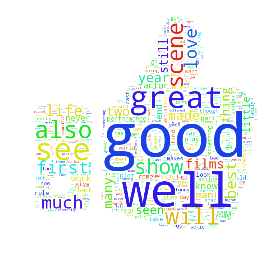

In [108]:
# Generate a word cloud image for the Positive reviews (Train Data)
good_mask = imread("thumbs-up-hand-symbol.png")

wordcloud = WordCloud(
stopwords=stopwords,
background_color='white',
max_words=500,
mask=good_mask,
width=7800,
height=4400
).generate(good_words_soup.get_text())
 
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./Good_cloudS4.png', dpi=300)
plt.show()

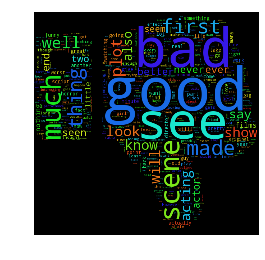

In [109]:
# Generate a word cloud image for the Negative reviews (Train Data)
good_mask = imread("thumbs-down-hand-symbol.png")

wordcloud = WordCloud(
stopwords=stopwords,
background_color='black',
max_words=500,
mask=good_mask,
width=7800,
height=4400
).generate(bad_words_soup.get_text())
 
plt.imshow(wordcloud)
plt.axis('off')
plt.savefig('./Bad_cloudS4.png', dpi=300)
plt.show()

In [113]:
bad_distinct_words = set(bad_words_soup.get_text())

print len(bad_distinct_words)
#bad_distinct_words

156


{u'\n',
 u' ',
 u'!',
 u'"',
 u'#',
 u'$',
 u'%',
 u'&',
 u"'",
 u'(',
 u')',
 u'*',
 u'+',
 u',',
 u'-',
 u'.',
 u'/',
 u'0',
 u'1',
 u'2',
 u'3',
 u'4',
 u'5',
 u'6',
 u'7',
 u'8',
 u'9',
 u':',
 u';',
 u'=',
 u'>',
 u'?',
 u'@',
 u'A',
 u'B',
 u'C',
 u'D',
 u'E',
 u'F',
 u'G',
 u'H',
 u'I',
 u'J',
 u'K',
 u'L',
 u'M',
 u'N',
 u'O',
 u'P',
 u'Q',
 u'R',
 u'S',
 u'T',
 u'U',
 u'V',
 u'W',
 u'X',
 u'Y',
 u'Z',
 u'[',
 u'\\',
 u']',
 u'^',
 u'_',
 u'`',
 u'a',
 u'b',
 u'c',
 u'd',
 u'e',
 u'f',
 u'g',
 u'h',
 u'i',
 u'j',
 u'k',
 u'l',
 u'm',
 u'n',
 u'o',
 u'p',
 u'q',
 u'r',
 u's',
 u't',
 u'u',
 u'v',
 u'w',
 u'x',
 u'y',
 u'z',
 u'{',
 u'|',
 u'}',
 u'~',
 u'\x80',
 u'\x84',
 u'\x85',
 u'\x8d',
 u'\x91',
 u'\x95',
 u'\x96',
 u'\x97',
 u'\xa0',
 u'\xa1',
 u'\xa2',
 u'\xa3',
 u'\xa7',
 u'\xa8',
 u'\xae',
 u'\xb4',
 u'\xb7',
 u'\xba',
 u'\xbd',
 u'\xbe',
 u'\xbf',
 u'\xc5',
 u'\xc9',
 u'\xd5',
 u'\xdc',
 u'\xdf',
 u'\xe0',
 u'\xe1',
 u'\xe2',
 u'\xe3',
 u'\xe4',
 u'\xe5',
 u'\xe6',
 u'

In [114]:
# Running Tokenize Words for Sample Reviews and Analysis the Number of Sentences for Good and Bad Reviews
print len(nltk.sent_tokenize(bad_words_soup.get_text()))
print "%.4f" % (len(nltk.sent_tokenize(bad_words_soup.get_text())) / 12500.0)

print len(nltk.sent_tokenize(good_words_soup.get_text()))
print "%.4f" % (len(nltk.sent_tokenize(good_words_soup.get_text())) / 12500.0)

#type(nltk.word_tokenize(neg_review_train_sample))
#type(nltk.word_tokenize(pos_review_train_sample))

134715
10.7772
128369
10.2695


In [115]:
bad_w = nltk.word_tokenize(bad_words_soup.get_text())
good_w = nltk.word_tokenize(good_words_soup.get_text())

In [116]:
def is_a_real_word(x):
    return x not in ".,[]:!'?&-;()''\\``"

In [117]:
cleaned_up_bad_w = [
    x.lower() 
        for x in bad_w
        if is_a_real_word(x)
]
cleaned_up_good_w = [
    x.lower() 
        for x in good_w
        if is_a_real_word(x)
]

In [118]:
distinct_bad_words = set(cleaned_up_bad_w)
distinct_good_words = set(cleaned_up_good_w)

In [120]:
# Lexical diversity of bad reviews
print len(distinct_bad_words)
print len(cleaned_up_bad_w)
# Multiply by 1.0 to make it a float. Good trick!!
lexical_diversity_of_bad_reviews = (len(distinct_bad_words))*1.0 / len(cleaned_up_bad_w)
print "%.4f" % lexical_diversity_of_bad_reviews

92390
2906093
0.0318


In [121]:
# Lexical diversity of good reviews
print len(distinct_good_words)
print len(cleaned_up_good_w)
# Multiply by 1.0 to make it a float. Good trick!!
lexical_diversity_of_good_reviews = (len(distinct_good_words))*1.0 / len(cleaned_up_good_w)
print "%.4f" % lexical_diversity_of_good_reviews

93147
2972069
0.0313


In [122]:
# Getting text objects for positive and negative reviews
pos_review_text_obj = nltk.Text(nltk.word_tokenize(good_words_soup.get_text()))

neg_review_text_obj = nltk.Text(nltk.word_tokenize(bad_words_soup.get_text()))

Displaying 25 of 1635 matches:
s.The cinematography speaks of the excellent skills of Josef Werching that acce
ave to say that The Mother does an excellent job of explaining the sexual desir
e . This movie brought to mind the excellent movies that Branagh made with Emma
lm started and ended so well , had excellent acting and writing , it 's hard no
ow , and she and Celeste have been excellent support networks to each other for
 Jim and his bride-to-be all do an excellent job of fitting into stereotypes of
id-fifties.All in all , this is an excellent anime series to watch if you are a
esel . Micheals and Perfect had an excellent match here , but it was Diesel who
 simply because some segments were excellent and covered issues that usually ge
ost movies since . Martin Sheen is excellent , and though Nick Nolte has a smal
has a small part , he too provides excellent support . Vic Morrow as the villai
elf . First of all , the acting is excellent , especially the leads . Although 
o respons

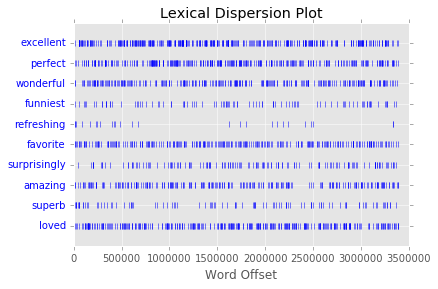

In [123]:
pos_review_text_obj.concordance('excellent')
pos_review_text_obj.common_contexts(['excellent'])
pos_review_text_obj.similar('excellent')
neg_review_text_obj.dispersion_plot(['excellent',
                                     'perfect', 
                                     'wonderful', 
                                     'funniest',
                                     'refreshing',
                                     'favorite',
                                     'surprisingly',
                                     'amazing',
                                     'superb',
                                     'loved'
                                    ]
                                   )

Displaying 25 of 2430 matches:
s from his mouth he just vomited the worst film of all time . '' '' '' `` `` ''
 way for a while , with the absolute worst element being Midkiff 's worthless p
 big groan-worthy twist at the end . Worst of all is the overlong `Zion Rave ' 
shreds ! ! ! ! ! \ '' '' That 's the worst part about this movie is , this shar
t BEN AND ARTHUR is quite simply the worst film I have ever sat through in my l
nt of view it is probably one of the worst films I have encountered absolutely 
cast Jeroen Krabbé because he 's the worst actor and every character he 's play
'm faced with here right ? It is the worst film ever because he 's supposed to 
not without competition for title of worst film so it has to sink pretty low to
 . '' '' '' `` `` '' This is n't the worst movie I 've ever seen , but I really
s just as well they have some of the worst - and not just the human characters 
big science fiction.It 's one of the worst movies I have ever seen ... Simply .
'' '' '' 

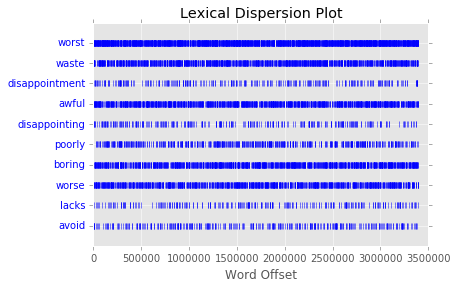

In [124]:
neg_review_text_obj.concordance('worst')
neg_review_text_obj.common_contexts(['worst'])
neg_review_text_obj.similar('worst')
neg_review_text_obj.dispersion_plot(['worst',
                                     'waste',
                                     'disappointment',
                                     'awful',
                                     'disappointing',
                                     'poorly',
                                     'boring',
                                     'worse',
                                     'lacks',
                                     'avoid'
                                    ]
                                   )